# Moneyball Revisit: MLB Team Runs Scored Prediction
<img src="https://techcrunch.com/wp-content/uploads/2016/04/moneyball.png?w=1390&crop=1" height = 360, width = 720/>
(Image from: https://techcrunch.com/2016/04/02/moneyball-is-dead-long-live-moneyball/)

# Table of Contents
1. [Motivation](#motivation)
2. [Data](#data)
3. [Data Cleaning](#data-cleaning)
4. [EDA (Exploratory Data Analysis)](#eda)
5. [Feature Selection](#feature-selection)
6. [Multiple Linear Regression](#mlr)
7. [Simple Linear Regression](#slr)
8. [Model Validation](#model-validation)
9. [Cross-era Comparision](#cross-era-comparision)
10. [Conclusion](#conclusion)

# 🤔 Motivation <a name="motivation"></a>
Before we dive into my analysis, let's briefly talk about the nature of baseball.

Say you are an owner of a baseball team, then why do you think you are running your team spending billions of dollars per year? 
Making money, making fans enthusiastic, having fans in ballparks and so on...<br>
But the ulitmate goal of running a baseball team, as with other sports teams, will be winning.

As the owner of your team, your goal should be winning, and thus, you should try to buy wins not just players. This is where **sabermetrics** ([SABR](https://sabr.org) + metrics) has originated. Interesting!

Now we understand that we should focus on wins, then HOW do we win? (i.e. what makes your team win?) As in other sports, a baseball team should score as much as possible while giving up runs as less as possible.

Alright, we're almost there. Your goal is to win, and therefore, your team must outscore your opponents to do so.
That's the nature of baseball: **Runs Scored** and **Runs Allowed**. <br>
In this project, we'll focus on the first part: **Runs Scored**.


# 📂 Data <a name="data"></a>
To perform the analysis, I've obtained 21st century (2000 ~ 2021 season) MLB team batting statistics data from [FanGraphs.com](https://www.fangraphs.com)

More about data features:
    
| **Metadata** | **Information** |
| :-----------: | :-----------: |
| **Origin of Data** | [FanGraphs.com](https://www.fangraphs.com) |
| **Terms of Service** | [Terms of Service](https://www.fangraphs.com/about/terms-of-service) |
| **Data Structure** | 22 datasets (**CSV** files) each of which consists of 30 rows * 23 columns |

| **Data Feature** | **Description** |
| :-----------: | :-----------: |
| **Season** | Each year refers to the corresponding season |
| **TEAM** | Team names |
| **G** | Total number of games played by all batters for each team |
| **PA** | [Plate Appearance](http://m.mlb.com/glossary/standard-stats/plate-appearance) |
| **AB** | [At-bat](http://m.mlb.com/glossary/standard-stats/at-bat) |
| **R** | [Runs Scored](http://m.mlb.com/glossary/standard-stats/run) |
| **H** | [Hit](http://m.mlb.com/glossary/standard-stats/hit) |
| **AVG** | [Batting Average](http://m.mlb.com/glossary/standard-stats/batting-average) |
| **OBP** | [On-base Percentage](http://m.mlb.com/glossary/standard-stats/on-base-percentage) |
| **SLG** | [Slugging Percentage](http://m.mlb.com/glossary/standard-stats/slugging-percentage) |
| **OPS** | [On-base Plus Slugging](http://m.mlb.com/glossary/standard-stats/on-base-plus-slugging) |
| **ISO** | [Isolated Power](http://m.mlb.com/glossary/advanced-stats/isolated-power) |
| **HR** | [Home run](http://m.mlb.com/glossary/standard-stats/home-run) |
| **BB** | [Walk](http://m.mlb.com/glossary/standard-stats/walk) |
| **SO** | [Strikeout](http://m.mlb.com/glossary/standard-stats/strikeout) |
| **SB** | [Stolen Base](http://m.mlb.com/glossary/standard-stats/stolen-base) |
| **CS** | [Caught Stealing](http://m.mlb.com/glossary/standard-stats/caught-stealing) |
| **wOBA** | [Weighted On-base Average](https://www.mlb.com/glossary/advanced-stats/weighted-on-base-average) |
| **wRC+** | [Weighted Runs Created Plus](https://www.mlb.com/glossary/advanced-stats/weighted-runs-created-plus) |
| **WAR** | [Wins Above Replacement](https://library.fangraphs.com/misc/war/) |

| **Newly Created Data** | **Description** |
| :-----------: | :-----------: |
| **League** | **AL**: American League / **NL**: National League |
| **Era** | Era segmentation |
| **TB** | [TB](https://www.mlb.com/glossary/standard-stats/total-bases) |

Alright, let's get started!

In [1]:
# install packages
!pip install pingouin
!pip install mlxtend

     |████████████████████████████████| 182 kB 625 kB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for pingouin: filename=pingouin-0.5.0-py3-none-any.whl size=193661 sha256=4a91bff7aca99b7c572f071ad5ed22ae6f3c1d6fbc13a10b3399d348d944470d
  Stored in directory: /root/.cache/pip/wheels/14/46/f9/cedd81d68d2515c24bbbd000d5b347e4fe092ccc4b568f7f70
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=c2c38467d5ea75239978c8aaa4670f151403dfd43a6e1534f3fe3a379e5d28ca
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# purpose of Analysis: predicting a team's runs scored based on various team batting statistics
# load datasets
path = "../input/mlb-team-batting-data/"
data_files = sorted([file for file in os.listdir(path)], reverse = True)

# empty dataframe
batting_df = pd.DataFrame()

# load data files one at a time and merge them into a single data frame
for file in data_files:
    df = pd.read_csv(path + file)
    batting_df = pd.concat([batting_df, df])

# first five rows of data
batting_df.head()

,Season,Team,G,PA,AB,R,H,AVG,OBP,SLG,OPS,ISO,1B,2B,3B,HR,BB,SO,SB,CS,wOBA,wRC+,WAR
0,2021,TOR,2383,6070,5476,846,1455,0.266,0.330,0.466,0.797,0.200,895,285,13,262,496,1218,81,20,0.340,113,30.5
1,2021,HOU,2319,6291,5593,863,1496,0.267,0.339,0.444,0.783,0.177,962,299,14,221,569,1222,53,16,0.336,116,33.9
2,2021,BOS,2353,6122,5495,829,1434,0.261,0.328,0.449,0.777,0.188,862,330,23,219,512,1386,40,21,0.333,107,23.2
3,2021,SFG,2597,6196,5462,804,1360,0.249,0.329,0.440,0.769,0.191,823,271,25,241,602,1461,66,14,0.329,108,30.0
4,2021,CHW,2292,6084,5357,796,1373,0.256,0.336,0.422,0.758,0.166,886,275,22,190,586,1389,57,20,0.329,109,25.3


# 🧹 Data Cleaning <a name="data-cleaning"></a>
With the code below, here's what I did:
- Combined 22 different datasets (2000-2021 Season Team Batting Data) when loading 22 datasets.
- Renamed **R** data feature as **RS** for clarity.
- Created new data features: **League**, **Era** and **TB**
- Confirmed that there are no missing duplicated data.
- Converted **object** data types into **category** data types to save memory usage.
- Reordered data features.

In [4]:
# 1. Data Cleaning
# rename specific column names
batting_df.rename(columns = {'R': 'RS'}, inplace = True)

# check missing data
print("Total number of missing values in each column:")
print(batting_df.isnull().sum())

# check duplicated data
print("Total number of duplicates in batting data: {}".format(batting_df.duplicated().sum()))

# create a new column for "Total Base (TB)" data
batting_df["TB"] = batting_df["1B"] + (2 * batting_df["2B"]) + (3 * batting_df["3B"]) + (4 * batting_df["HR"])

# export league data: National League (NL) / American League (AL)
nl_teams = ["ATL", "CHC", "CIN", "COL", "LAD",
            "MIL", "NYM", "PHI", "PIT", "SDP",
            "SFG", "STL", "ARI", "WSN", "FLA",
            "MIA", "MON"]
al_teams = ["MIN", "CHW", "CLE", "DET", "KCR",
            "TOR", "BAL", "BOS", "NYY", "OAK",
            "SEA", "TEX", "LAA", "TBR", "TBD",
            "ANA"]

# define leagues: NL / AL
def get_league(data):
    if data["Team"] in nl_teams:
        return "NL"
    elif data["Team"] in al_teams:
        return "AL"
    elif data["Team"] == "HOU" and data["Season"] <= 2012:
        return "NL"
    else:
        return "AL"

batting_df["League"] = batting_df.apply(lambda x: get_league(x), axis = 1)

# check data types
print(batting_df.dtypes)

# check memory usage
print("Total Memory Usage Before: {}".format(batting_df.memory_usage(deep = True).sum()))

# to save memory usage, change "League" and "Team" data type
batting_df["Team"] = batting_df["Team"].astype("category")
batting_df["League"] = batting_df["League"].astype("category")

print("Total Memory Usage After: {}".format(batting_df.memory_usage(deep = True).sum()))

# reorder data columns
cols = ["Season", "League"] + list(batting_df.columns)[1:-1]
batting_df = batting_df.reindex(columns = cols)

Total number of missing values in each column:
Season    0
Team      0
G         0
PA        0
AB        0
RS        0
H         0
AVG       0
OBP       0
SLG       0
OPS       0
ISO       0
1B        0
2B        0
3B        0
HR        0
BB        0
SO        0
SB        0
CS        0
wOBA      0
wRC+      0
WAR       0
dtype: int64
Total number of duplicates in batting data: 0
Season      int64
Team       object
G           int64
PA          int64
AB          int64
RS          int64
H           int64
AVG       float64
OBP       float64
SLG       float64
OPS       float64
ISO       float64
1B          int64
2B          int64
3B          int64
HR          int64
BB          int64
SO          int64
SB          int64
CS          int64
wOBA      float64
wRC+        int64
WAR       float64
TB          int64
League     object
dtype: object
Total Memory Usage Before: 205260
Total Memory Usage After: 131378


# 📊 EDA (Exploratory Data Analysis) <a name="eda"></a>
In this section, I'll statistically analyze the response variable: **Team Runs Scored (RS)** <br>
Before we do the analyses, let's first have a look at the **descriptive statistics** of RS.

## 4-1. MLB Team Runs Scored Descriptive Statistics
| **Count** | **Mean** | **Std** | **Min** | **25%** | **50%** | **75%** | **Max** |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| 660 | 719.33 | 125.87 | 219 | 672.75 | 731 | 791 | 978 |

By looking at the table above, we can notice that the **minimum RS** is 219, while the **maximum RS** 978, and thus, the **range of RS** is 759. However, the **standard deviation** is about 125.87 so it's pretty large compared to the range of data. There may be something weird going on 🤔

## 4-2. Runs Scored Analysis 1: How did the league average runs scored change over time?
Okay, the first analysis is to detect how the league mean RS changed over time.
To do so, I'll first visualize the league average RS data using **a bar plot** and **box plot**.

------- Yearly Changes in League Average Runs Scored -------
    Season     RS
0     2000  832.4
1     2001  773.3
2     2002  746.9
3     2003  765.9
4     2004  779.2
5     2005  744.2
6     2006  786.6
7     2007  777.4
8     2008  752.8
9     2009  747.3
10    2010  710.3
11    2011  693.6
12    2012  700.6
13    2013  675.2
14    2014  658.7
15    2015  688.2
16    2016  724.8
17    2017  752.7
18    2018  721.0
19    2019  782.2
20    2020  278.1
21    2021  733.7


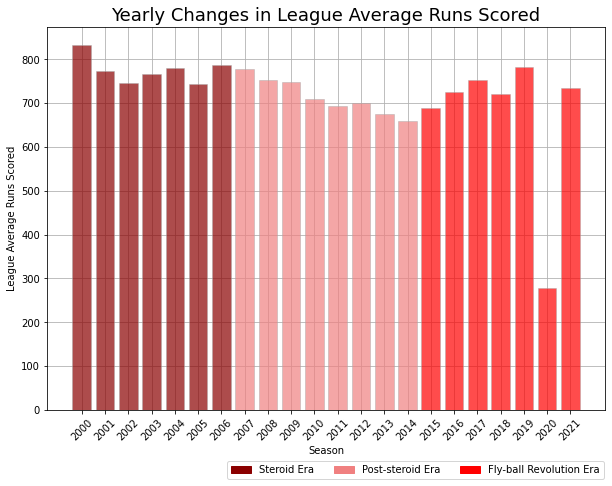

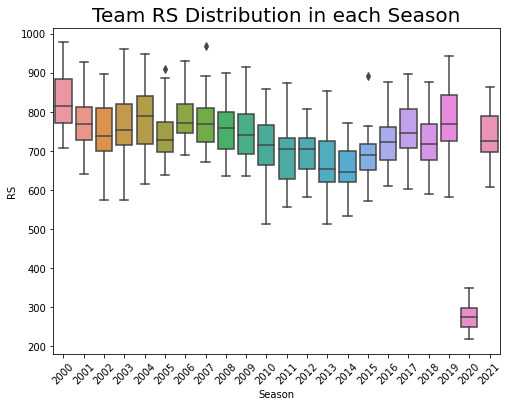

In [5]:
season_df = batting_df.groupby("Season")
lg_avg_rs = season_df["RS"].mean().round(1).reset_index()
print("------- Yearly Changes in League Average Runs Scored -------")
print(lg_avg_rs)

# bar plot
values = np.array(lg_avg_rs["RS"])
idx = np.array(lg_avg_rs["Season"])
c1 = mpatches.Patch(color = "darkred", label = "Steroid Era")
c2 = mpatches.Patch(color = "lightcoral", label = "Post-steroid Era")
c3 = mpatches.Patch(color = "red", label = "Fly-ball Revolution Era")

fig, ax = plt.subplots(figsize = (10, 7))

plt.bar(idx, values, edgecolor = "darkgrey", linewidth = 0.6,
        color = ["darkred"] * 7 + ["lightcoral"] * 8 + ["red"] * 7,
        alpha = 0.7, zorder = 3)
plt.xticks(lg_avg_rs["Season"], rotation = 45)
plt.xlabel("Season")
plt.ylabel("League Average Runs Scored")
plt.title("Yearly Changes in League Average Runs Scored", fontsize = 18)
plt.legend(handles = [c1, c2, c3], ncol = 3,
           bbox_to_anchor= (0.66, -0.12), loc = "upper center")
plt.grid(zorder = 0)
fig.subplots_adjust(bottom = 0.12)
plt.show()

# box plot
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(x = "Season", y = "RS", data = batting_df, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title("Team RS Distribution in each Season", fontsize = 20)
plt.show()

The bar plot and box plot above show how the **league median RS** changed over time since 2000. As we can see, although there were slight fluctuations, *teams were able to score relatively many runs up until the mid 2000's (2000 ~ 2006) on average*.

However, such a trend seemed to reverse after the 2006 season. For some reason, *there was a clear downward trend in the league median RS until 2014 season*. Then *it has been increasing again since 2015 except one weird season: 2020*. <br>

⚠️ Note that the 2020 season was **an abnormal 60-game season** due to the pandemic, while teams usually play 162 games in a normal season.

Alright, it *looks* like there are differences in the league median RS across different eras, but can we do a more statistical analysis to figure out if such differences are really *siginificant*? Yes: **One-way ANOVA F-test and Post-hoc test**

### ❗️Era segmentation
To perform one-way ANOVA, I first segmented seasons. <br>
For many baseball fans, it's well-known that the MLB history is segmented into several eras based on **Runs Scored environment changes** that correspond with external factors, such as changes in rules/balls, PEDs abuse, etc. Some examples are: <br>
- MLB players abused PEDs since the mid 1990's up until the mid 2000's - **Steroid Era**.
- After the drug scandal, MLB's drug testing and penalties became strict to prevent players from being helped by PEDs - **Post-steroid Era**. 
- With the help of a new technology, **Statcast**, sabermetricians found that if hitters hit try to hit fly balls rather than ground balls by increasing their [lauch angles](https://www.mlb.com/glossary/statcast/launch-angle), it increases the chances of hitting home runs - **Fly-ball Revolution Era**. <br>

Since the bar plot above also captures the reality, I segmented seasons on the basis of the corresponding RS environment observed from the bar plot above.<br>
The era segmentation was done as follows:

| **Season** | 2000 - 2006 | 2007 - 2014 | 2014 - 2021 |
| :-----------: | :-----------: | :-----------: | :-----------: |
| **Era** | Steroid Era | Post-steroid Era | Fly-ball Revolution Era |

In [6]:
# divide seasons into "Era" groups
def get_era(data):
    if data["Season"] <= 2006:
        return "Steroid Era"
    elif data["Season"] > 2006 and data["Season"] <= 2014:
        return "Post-steroid Era"
    else:
        return "Fly-ball Revolution Era"

batting_df["Era"] = batting_df.apply(lambda x: get_era(x), axis = 1)
batting_df["Era"] = batting_df["Era"].astype("category")

Okay, now we're ready to perform one-way ANOVA. The factor is **Era segmentation**, while the response variable is **RS**. <br>
Let's check the ANOVA assumptions: *Normality*, *Equal-variance* and *Independence*.

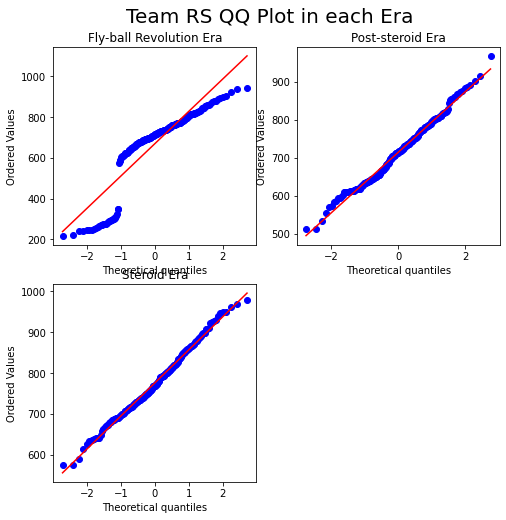

In [7]:
# check one-way ANOVA assumptions
# normality
eras = batting_df["Era"].unique()
fig = plt.figure(figsize = (8, 8))

for era, i in zip(eras, range(1, 5)):
    ax = fig.add_subplot(2, 2, i)
    stats.probplot(batting_df.loc[batting_df["Era"] == era]["RS"], plot = plt)
    ax.set_title("{}".format(era))
    ax.set
fig.suptitle("Team RS QQ Plot in each Era", fontsize = 20, y = 0.95)
plt.show()

Opps, as I expected when talking about RS descriptive statistics above, team RS observations in *the fly-ball revolution era* are **not normally distributed**. <br>
But don't worry, it's because of the abnormal short 2020 season data, as teams only played 60 games and hence scored much fewer runs than usual. <br>
For this reason, **I'll not use 2020 season data from now on**.

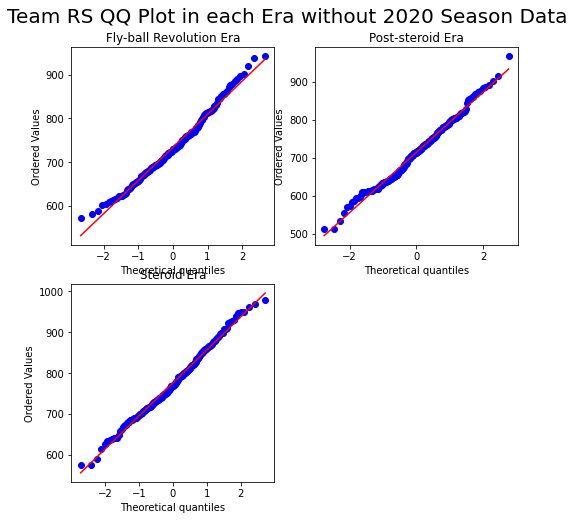

------- Team Runs Scored Descriptive Statistics by Era -------
                         count        mean        std    min     25%    50%     75%    max
Era                                                                                       
Fly-ball Revolution Era  180.0  733.777778  75.455974  573.0  682.75  729.0  777.25  943.0
Post-steroid Era         240.0  714.479167  79.132956  513.0  650.00  714.5  770.00  968.0
Steroid Era              210.0  775.509524  80.319651  574.0  718.25  768.5  826.75  978.0


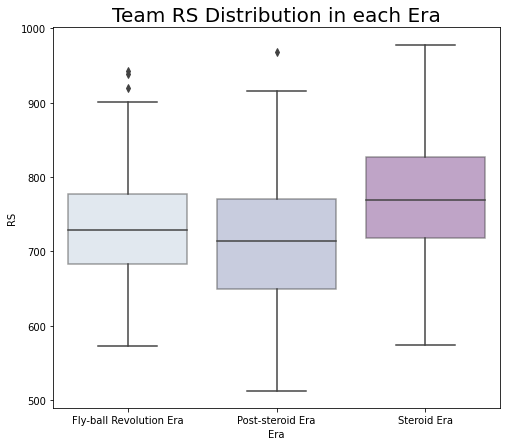

In [8]:
# since Fly-ball Era "RS" are not normally distributed due to 2020 season data,
# drop 2020 season data (abnormal 60-game season = outliers)
batting_df = batting_df.loc[batting_df["Season"] != 2020]

# check the normality assumption again
eras = batting_df["Era"].unique()
fig = plt.figure(figsize = (8, 8))

for era, i in zip(eras, range(1, 5)):
    ax = fig.add_subplot(2, 2, i)
    stats.probplot(batting_df.loc[batting_df["Era"] == era]["RS"], plot = plt)
    ax.set_title("{}".format(era))
fig.suptitle("Team RS QQ Plot in each Era without 2020 Season Data", fontsize = 20, y = 0.95)
plt.show()

# equal-variance
# descriptive statistics
era_df = batting_df.groupby("Era")
rs_sum_era = era_df["RS"].describe()
print("------- Team Runs Scored Descriptive Statistics by Era -------")
print(rs_sum_era.to_string())

# box plot
fig, ax = plt.subplots(figsize = (8, 7))

sns.boxplot(x = "Era", y = "RS", data = batting_df, ax = ax,
            palette = "BuPu", boxprops = dict(alpha = 0.5))
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title("Team RS Distribution in each Era", fontsize = 20)
plt.show()

Okay, after dropping 2020 season data, we're now in a better position to perform a one-way ANOVA, as normality and equal-variance assumptions are satisfied! Also, note that all the observations are indpendent of each other.

The null and alternative hypothses of the one-way ANOVA F-test are: <br>
$$H_0: \mu_1 = \mu_2 = \mu_3 \ \ \ \text{vs} \ \ \ H_1: \ \text{at least one} \ \mu_i \ne \mu_j$$

⚠️ For simplicity, 1 = Steroid Era, 2 = Post-steroid Era, 3 = Fly-ball Revolution Era

In [9]:
# one-way ANOVA F-test
model = ols("RS ~ C(Era)", data = batting_df).fit()
one_aov_table = sm.stats.anova_lm(model, typ = 1)
print("------- One-way ANOVA F-test Result -------")
one_aov_table.round(3)
# since the p-value is approximately 0,
# we have significant evidence that is at least one pairwise group mean difference in "RS"

------- One-way ANOVA F-test Result -------


,df,sum_sq,mean_sq,F,PR(>F)
C(Era),2.0,428007.172,214003.586,34.725,0.0
Residual,627.0,3864089.488,6162.822,NaN,NaN


According to the one-way ANOVA F-test table above, **TMS (Treatment Mean Square)** is much larger than **RMS (Residual Mean Square)**: 214003.586 vs 6162.822, resulting in a large **F-statistic** of 34.725. <br>
Some mathematical details are:
- $ \text{RMS}=\frac{1}{N-g}\sum^{3}_{i=1}\sum^{n_i}_{j=1}(y_{ij}-\bar{y}_{i\bullet})^2 $
- $ \text{TMS}=\frac{1}{g-1}\sum^{3}_{i=1}n_i(\bar{y}_{i\bullet}-\bar{y}_{\bullet\bullet})^2 $
- $ \text{F-statistic}=\frac{TMS}{RMS}\sim F_{g-1, N-g} \ \text{under} \ H_0 $ <br>
⚠️ $ i $ represents $i^{th}$ group for $ i = 1, 2, 3 $,  $ g = \ \text{Total number of groups (Eras)}$ and $ N = \ \text{Total number of observations}$.

It's simple.
- TMS measures how individual group (**Era**) mean RS are different from the overall mean RS on average.
- RMS meausres how individual data observations are different from the corresponding group (**Era**) mean RS *within each of these three groups (Eras)* on average.
- Hence, if TMS is relatively large compared to RMS resulting in a large F-statistic and small p-value, it indicates that the treatment factor (**Era**) significantly affects the response variable (**RS**).

As the p-value is approximately 0, **we reject $H_0$ and have strong evidence that there's at least one pairwise group mean difference in Team RS at a 5% significance level**

In [10]:
# one-way ANOVA post hoc test with a Bonferroni correction
compar = mc.MultiComparison(batting_df['RS'], batting_df['Era'])
table, a1, a2 = compar.allpairtest(stats.ttest_ind, method = "bonf")
print("------- One-way ANOVA Post Hoc Test Result -------")
table

------- One-way ANOVA Post Hoc Test Result -------


group1,group2,stat,pval,pval_corr,reject
Fly-ball Revolution Era,Post-steroid Era,2.5229,0.012,0.036,True
Fly-ball Revolution Era,Steroid Era,-5.2596,0.0,0.0,True
Post-steroid Era,Steroid Era,-8.1051,0.0,0.0,True


From the one-way ANOVA F-test, we now know there's at least one pairwise group mean difference in team RS. But which ones are different? <br>
To find out which specific groups have statistically significant difference in mean RS, I also performed a **one-way ANOVA post hoc test** with a **Bonferroni correction**.

The reason I chose to use a Bonferroni correction despite its **conservativeness** rather than **Tukey's method** is:
- There are only 3 groups (eras): $g=3$, and hence, the total number of possible combinations is also 3: $k={g \choose 2}=3$.
- Thus, even if we correct each individual unadjusted p-value by multiplying it by $k={g \choose 2}=3$, the p-value will not increase significantly.
- What's more the sample size of each group is different, and thus, Tukey's method may not work in this situation.

The one-way ANOVA post hoc test result table above shows that the largest **adjusted p-value (pval_corr)** is less than 0.05, indicating that all the pairwise group mean differences are statistically significant at a 5% significance level.

🚀 **Bottom line**: We've detected noticeable trends in the league average RS from the bar plot and box plot, and such differences have been proven to be statistically significant through one-way ANOVA!

## 4-3. RS Analysis: In which League (NL vs AL) did teams scored more?
Apart from **Era** there is another factor that may affect team RS: American League (AL) vs National League (NL). <br>
In the American league there are 9 batters in the lineup, while in the National league, there are 8 batters and 1 pitcher whose main job is pitching, not hitting, and therefore, American league teams have a better chance to score runs since pitchers are almost always bad hitters.

In this section, the treatment factor is now the **League**: whether AL or NL and the response variable is still team RS. <br>
Let's first have a look at descriptive statistics.

In [11]:
# 2-2. RS Analysis: In which League (NL vs AL) did teams scored more?: Two-sample t-test
# group data based on "League" data values
lg_df = batting_df.groupby("League")
leagues = batting_df["League"].unique()
print("------- Team Runs Scored Descriptive Statistics by League -------")
print(lg_df["RS"].describe())

nl_rs = batting_df.loc[batting_df["League"] == "NL"]["RS"]
al_rs = batting_df.loc[batting_df["League"] == "AL"]["RS"]

------- Team Runs Scored Descriptive Statistics by League -------
        count        mean        std    min     25%    50%     75%    max
League                                                                   
AL      302.0  759.360927  85.364601  513.0  700.25  751.0  816.75  978.0
NL      328.0  722.820122  75.999646  513.0  667.75  723.5  773.25  968.0


The average team RS is certainly different. (AL: 759.36 vs NL: 722.82) <br>
Let's visualize it.

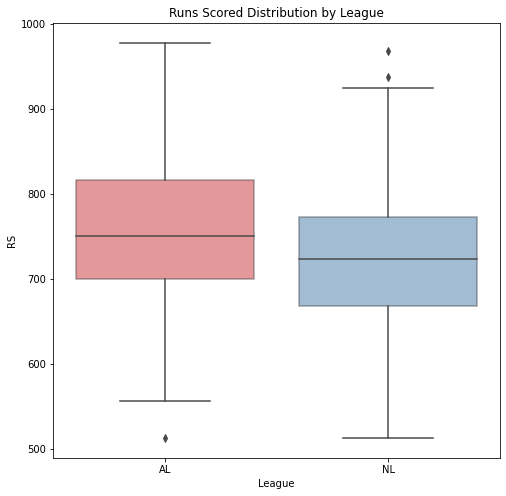

In [12]:
# box plot
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(x = "League", y = "RS", data = batting_df, palette = "Set1", boxprops = dict(alpha = 0.5))
ax.set(title = "Runs Scored Distribution by League")
plt.show()

We can easily notice that NL teams scored relatively fewer runs than AL teams over the past 20 years on average. <br>
However, how do we know this difference is staitstically significant?: **Two-sample t-test**.

As the treatment factor **League** has two independent groups: AL vs NL, we can perform a two-sample t-test to find out if there's a clear mean RS difference, as long as all the assumptions are satisfied.

Let's check the assumptions for the two-sample t-test.

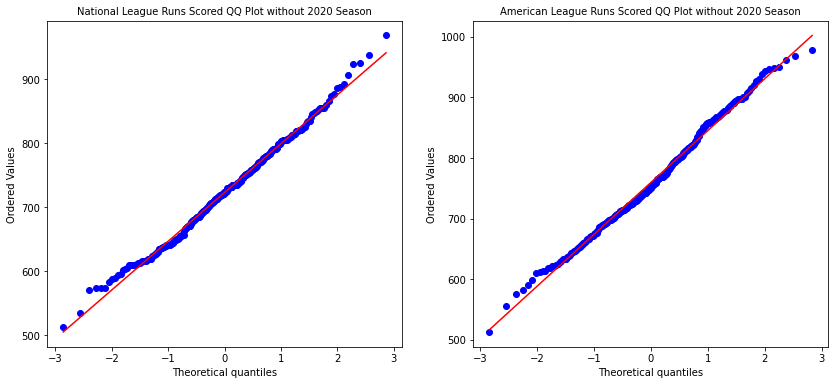

In [13]:
# check two-sample t-test assumptions
# normality
nl_rs = batting_df.loc[batting_df["League"] == "NL"]["RS"]
al_rs = batting_df.loc[batting_df["League"] == "AL"]["RS"]

fig, axes = plt.subplots(1, 2, figsize = (14, 6))
stats.probplot(nl_rs, plot = axes[0])
stats.probplot(al_rs, plot = axes[1])
axes[0].set_title("National League Runs Scored QQ Plot without 2020 Season", fontsize = 10)
axes[1].set_title("American League Runs Scored QQ Plot without 2020 Season", fontsize = 10)
plt.show()

Pooled two-sample t-test assumptions:

- Observations are roughly close to the diagonal lines in the QQ plots <br>
👉 The normality assumption ✅

- IQR of the two box plots are roughly identical <br>
👉 The equal-variance assumption ✅

- AL teams and NL teams are independent of each ohter, and the individual observations within each of these two leagues are also independent <br>
👉 The independence assumption ✅

Let's now perform a **pooled two-sample t-test**. The hypotheses are:
$H_0: \mu_{\text{AL}} = \mu_{\text{NL}} \ \ \ \text{vs} \ \ \ H_1: \mu_{\text{AL}} > \mu_{\text{NL}}$

In [14]:
# Pooled two-sample t-test
test_result = pg.ttest(al_rs, nl_rs, paired = False, alternative = 'greater', correction = False).round(3)
print("------- Pooled two-sample t-test result -------")
test_result

------- Pooled two-sample t-test result -------


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.683,628,greater,0.0,"[25.95, inf]",0.453,9.036e+05,1.0


According to the t-test result, the p-value is approximately 0, and thus, we reject $H_0$ and have strong evidence that AL teams scored more runs than NL teams on average at a 5% significance level.

## 4-4. RS Analysis: Is there interaction between "Era" and "League"?
So far, we've analyzed how **Era** and **League** factors affect team average RS *individually*. However, is the effect of **Era** the same across all levels of **League** (i.e., AL and NL)? <br>
To answer this question, I performed a **two-factor ANOVA** (or two-way ANOVA), where factor 1 is **Era**, factor 2 is **League** and the response variable is **RS**.

In [15]:
# 2-3. RS Analysis: Do both "Era" and "League" affect the team "RS"?
# two-factor ANOVA F-test
# factor 1: "Era" and factor 2: "League"
model = ols("RS ~ C(Era) + C(League) + C(Era):C(League)", data = batting_df).fit()
two_aov_table = sm.stats.anova_lm(model, typ = 2)
print("------- Two-factor ANOVA Table -------")
two_aov_table.round(3)

------- Two-factor ANOVA Table -------


,sum_sq,df,F,PR(>F)
C(Era),434873.929,2.0,37.325,0.000
C(League),216807.370,1.0,37.217,0.000
C(Era):C(League),12134.950,2.0,1.042,0.354
Residual,3635147.168,624.0,NaN,NaN


From the two-factor ANOVA table above, we can calculate TMS and RMS. <br>
- $\text{TMS for Era}=\frac{\text{TSS for Era}}{df}=\frac{434873.929}{2}\approx 217436.96$
- $\text{TMS for League}=\frac{\text{TSS for League}}{df}=\frac{216807.37}{1}\approx 216807.37$
- $\text{Interaction MS}=\frac{\text{Interaction SS}}{df}=\frac{12134.95}{2}\approx 6067.48$
- $\text{RMS}=\frac{\text{RSS}}{df}=\frac{3635147.168}{624}\approx 5825.56$

Based on these statistics, we can now make inferences about various effects on team RS. 
- Given that **TMS for Era** is much larger than RMS, we obtained a large F-statistic of 37.325 <br>
👉 **Era** affects team RS
- Given that **TMS for League** is much larger than RMS, we obtained a large F-statistic of 37.217 <br>
👉 **League** affects team RS
- However, as **Interaction MS** is not as much larger than RMS as two **TMS**s, we obtained a much smaller F-statistic of 1.042 <br>
👉 Since the p-value is greater than 0.05, we don't reject $H_0$ and don't have strong evidence that the effect of **Era** is different across all levels of **League** (i.e, AL or NL)

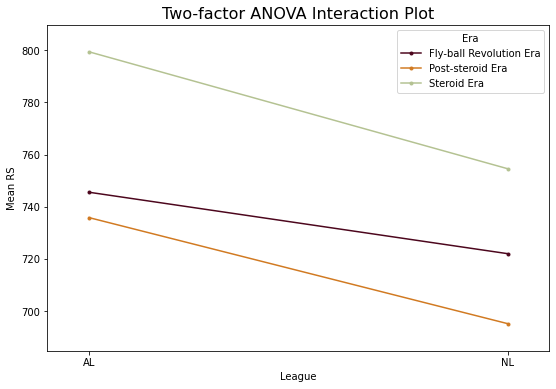

In [16]:
# interaction plot
fig, ax = plt.subplots(figsize = (9 ,6))
interaction_plot(x = batting_df["League"], trace = batting_df["Era"], response = batting_df["RS"],
                       colors = ['#4c061d','#d17a22', '#b4c292'], ax = ax)
plt.title("Two-factor ANOVA Interaction Plot", fontsize = 16)
plt.ylabel("Mean RS")
plt.show()

Given that the lines are parallel and don't intercept, this interaction plot also shows that there's no interaction effect. <br>
Alright, to validate our result, let's check the two-factor ANOVA assumptions.

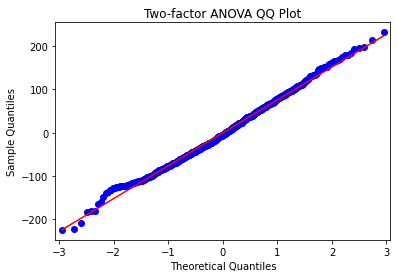

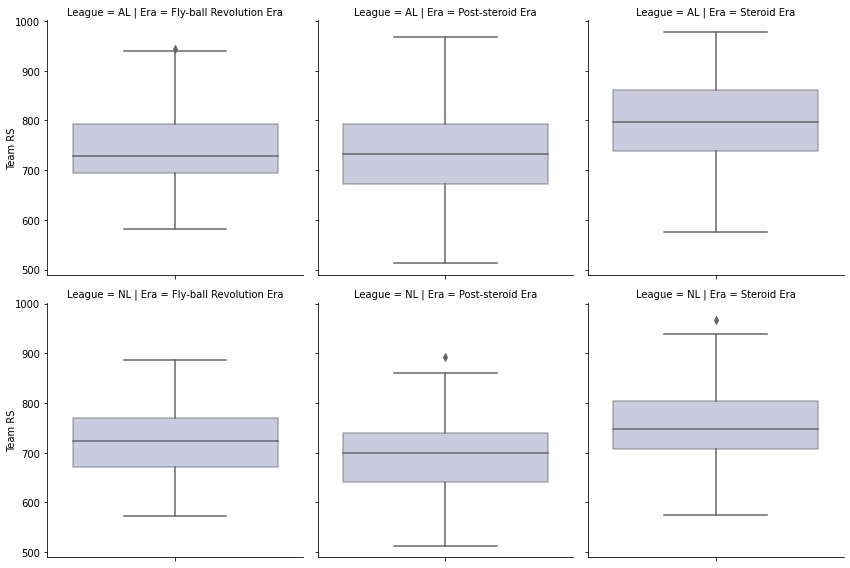

In [17]:
# check ANOVA assumptions
# normality
fig = sm.qqplot(model.resid, line = "s")
plt.title("Two-factor ANOVA QQ Plot")
plt.show()

# equal-variance
g = sns.FacetGrid(batting_df, col = "Era", row = "League", height = 4, aspect = 1)
g.map_dataframe(sns.boxplot, y = "RS", data = batting_df,
                palette = "BuPu", boxprops = dict(alpha = 0.5))
g.set_axis_labels(y_var = "Team RS", labelpad = -2)
plt.show()

Two-factor ANOVA assumptions: <br>
- residuals are roughly close to the diagnol line<br>
👉 The normality assumption ✅
- IQR of box plots are roughly identical <br>
👉 The equal-variance assumption ✅
- Observations are independent of each other <br>
👉 The independence assumption ✅

## 4-5. 🚀 MLB Team RS Analysis Conclusion
Both **Era** and **League** factors affect Team RS *individually* at a 5% significance level. <br>
However, there is no interaction effect❗️

# ☑️ Feature Selection <a name="feature-selection"></a>
In this section, I'll focus on featuere preprocessing for further predictive analysis using a multiple linear regression model. <br>
The initial number of (*numerical*) independent variables is 22

Let's visualize the correlations between all independent variables and the response vairable **RS**.

Initial total number of numerical independent variables: 22


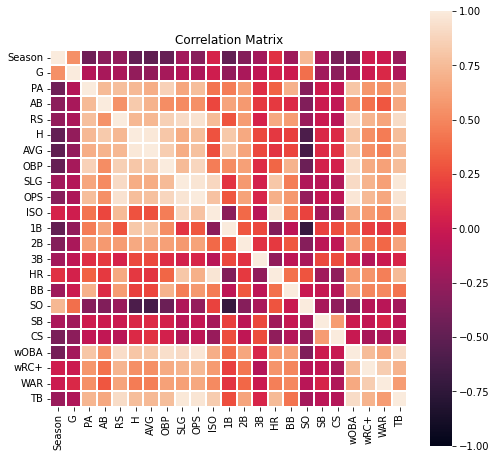

In [18]:
# initial total number of numerical independent variables (i.e., except the response variable "RS")
init_var_num = len(batting_df.select_dtypes(exclude = "category").columns)
print("Initial total number of numerical independent variables: {}".format(init_var_num - 1))

# correlation matrix
corrMatrix = batting_df.corr()
fig, ax = plt.subplots(figsize = (8, 8))

sns.heatmap(corrMatrix, square = True, linewidths = 0.3, vmax = 1, vmin = -1)
plt.title('Correlation Matrix')
plt.show()

### ⚠️ Multicollinearity
Looking at the correlation heatmap above, some independent variables are highly correlated with each other, which may potentiallly cause multicollinearity when building a multiple linear regression model. But why does multicollinearity matter

Say, you included all independent variables available in your multiple linear regression model. If independent variables $x_1$ and $x_2$ are highly correlated with each other, then estimated coefficients (slopes $\beta_1$ and $\beta_2$) can be very sensitive to small changes in either $x_1$ or $x_2$ reducing the precision of estimated coefficients of your model.

So if your goal is to make *accuate* predictions about a response variable, we must deal with multicollinearity.

Let's first filter some of these independent variables based on **the correlation between independent variables and RS**.

In [19]:
# 3-1. first drop variables that have lower (absolute) correlations with 'RS' than 0.65
corrMatrix = abs(batting_df.corr())
cols = list(corrMatrix.columns)
vars_to_drop = []
for col in cols:
    if corrMatrix[col]['RS'] < 0.65:
        vars_to_drop.append(col)

filtered_df = batting_df.loc[:, ~batting_df.columns.isin(vars_to_drop)]
filtered_vars = list(filtered_df.select_dtypes(exclude = "category").columns)
print(filtered_vars)

['PA', 'RS', 'H', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'HR', 'wOBA', 'wRC+', 'TB']


After filtering variables whose absolute correlation with RS is less than 0.65, we have **12 predictors**. <br>
Now let's have a look at *pairwise correlations* between independent variables. This time, I'll exclude independent variables that have **high pairwise correlations**.

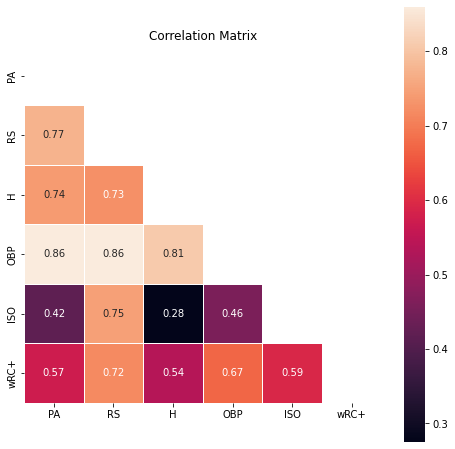

In [20]:
# 3-2. drop any independent variables if its pairwise correlation between other independent variables is higher than 0.9
ind_vars_df = filtered_df.iloc[:, filtered_df.columns != 'RS']

corrMatrix = abs(filtered_df.corr())
upperTri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
vars_to_drop = [col for col in upperTri.columns if any(upperTri[col] >= 0.9)]
filtered_df.drop(vars_to_drop, axis = 1, inplace = True)

# new correlation matrix for filtered data features
new_corr = filtered_df.corr()
fig, ax = plt.subplots(figsize = (8, 8))

mask = np.triu(np.ones_like(new_corr))
sns.heatmap(new_corr, mask = mask, square = True, linewidths = 0.5, annot = True, annot_kws = {'size': 10},
            xticklabels = new_corr.columns, yticklabels = new_corr.columns)
plt.title('Correlation Matrix')

plt.show()

After we consider high pairwise correlations between independent variables, we ended up **5 predictors**. However, it's still not enough to deal with multicollinearity. <br>
To find the best predictors for a multiple linear regression model, I'll use a wrapper method: **Recursive Feature Elimination (RFE)**.

In [21]:
# 3-3. Recursive Feature Elimination
# select numerical data
num_df = filtered_df.select_dtypes(exclude = "category")
x = num_df.loc[:, num_df.columns != 'RS']
y = num_df['RS']
cols = list(x.columns)

model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 2, verbose = 2)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars))

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
RFE Features: ['OBP', 'ISO']


According to RFE, the best two predictors are: **OBP** and **ISO**. To validify the result, let's check out **Variance Inflation Factor (VIF)** scores.

In [22]:
# check VIF
x = num_df[selected_vars]
x = sm.add_constant(x)
y = num_df['RS']

lm = sm.OLS(y, x)
result_rs = lm.fit()
print(result_rs.summary())

vif = pd.DataFrame()
vif['Feature'] = lm.exog_names
vif['VIF'] = [variance_inflation_factor(lm.exog, i) for i in range(lm.exog.shape[1])]
print(vif[vif['Feature'] != 'const'])

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2696.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):          1.16e-308
Time:                        12:21:57   Log-Likelihood:                -2961.9
No. Observations:                 630   AIC:                             5930.
Df Residuals:                     627   BIC:                             5943.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -772.5955     24.460    -31.587      0.0

The VIF score of 1.269 suggests that there is a low level of multicollinearity! Likewise, both predictors are considered significant as their t-statistics are large resulting in approximate p-values of 0.

With these two predictors, let's build a multiple linear regression model splitting the data into training and test data sets to prevent overfitting data.

# 📈 Multiple Linear Regression <a name="mlr"></a>
With the selected features **OBP** and **ISO** above, I'll now build a multiple linear regression model with 80% training data sets and 20% test data sets. <br>

## Linear Regression Assumptions
However, before building a regression model we must check all linear regression assumptions:
- Linearity
- Homoscedasticity
- Normality
- Independence

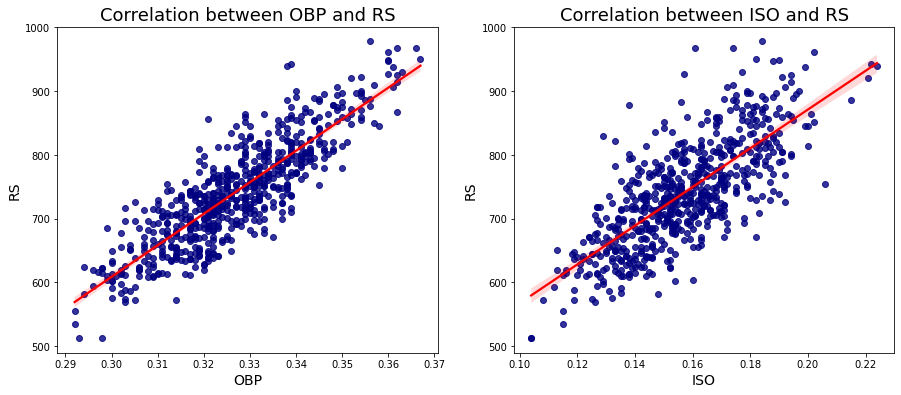

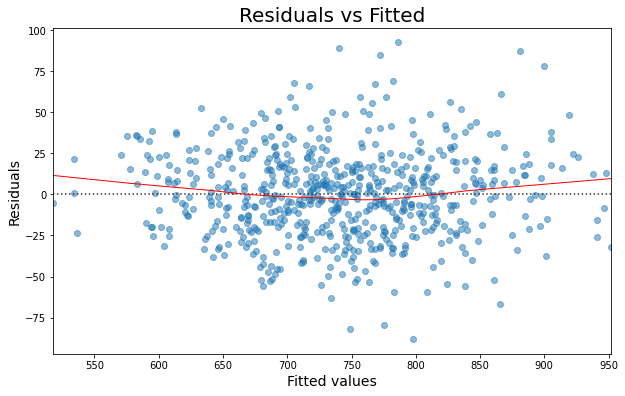

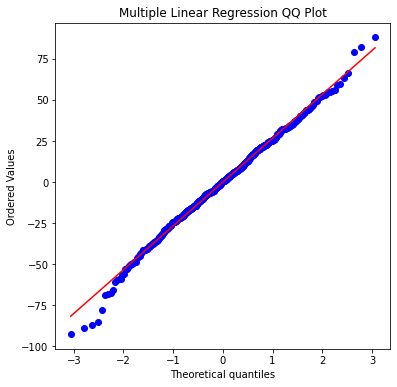

In [23]:
# select final features for multiple linear regression model
mlr_df = batting_df.loc[:, ["RS", "OBP", "ISO"]]

# linearity
# scatter plots
cols = list(mlr_df.drop('RS', axis = 1).columns)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

for col, ax in zip(cols, axes.flatten()[:2]):
    sns.regplot(x = col, y = 'RS', data = mlr_df, scatter_kws = {'color': 'navy'},
                line_kws = {'color': 'red'}, ax = ax)
    ax.set_title('Correlation between {} and RS'.format(col), fontsize = 18)
    ax.set_xlabel(col, fontsize = 14)
    ax.set_ylabel('RS', fontsize = 14)

plt.show()

# homoscedasticity
# residual plot
model = linear_model.LinearRegression().fit(x, y)
fitted_y = model.predict(x)
resid = fitted_y - y

fig = plt.subplots(figsize = (10, 6))
sns.residplot(fitted_y, "RS", data = mlr_df, lowess = True,
              scatter_kws = {"alpha": 0.5}, line_kws = {"color": "red", "lw": 1})
plt.xlabel("Fitted values", fontsize = 14)
plt.ylabel("Residuals", fontsize = 14)
plt.title("Residuals vs Fitted", fontsize = 20)
plt.show()

# normality
# QQ plot
fig = plt.subplots(figsize = (6, 6))
stats.probplot(resid, dist = "norm", plot = plt)
plt.title("Multiple Linear Regression QQ Plot")
plt.show()

- **Linearity**: According to the first two scatter plots, there seem to be clear linear trends between each independent variable and the response variable. Likewise, the residual plot shows that most residuals are close to 0, indicating that the linearity assumption is satisfied.

- **Homoscedasticity**: Although there exists slight fanning in the residual plot, the homoscedasticity assumption is not too badly violated in general, and hence, it's not something to get too worried about.

- **Normality**: The normality assumption is definitely satisfied here, as the majority of observations are close to the diagonal line in the QQ plot.

- **Independence**: As with previous analyses, observations are independent of each other, and thus, the independence assumption is satisfied.

In [24]:
# 4. Multiple Linear Regression with feature selection
# split data into training and test data and build a multiple linear regression model
# multiple linear regression (x:'OBP', 'ISO' / y:'RS')
x = mlr_df[selected_vars]
y = mlr_df['RS']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

mlr = linear_model.LinearRegression().fit(x_train, y_train)
y_predicted = mlr.predict(x_test)

# multiple linear regression results
print('------- Multiple Linear Regression -------')
print("Intercept: {}".format(mlr.intercept_))
print("Coefficients: {}".format(mlr.coef_))

print("R-squared: {}".format(metrics.r2_score(y_test, y_predicted)))
mse = metrics.mean_squared_error(y_test, y_predicted)
print("RMSE: {}".format(sqrt(mse)))
print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

------- Multiple Linear Regression -------
Intercept: -774.4337019861648
Coefficients: [3766.40745563 1815.95279324]
R-squared: 0.9026667822786473
RMSE: 25.114785716690623
MAE: 19.157991588611104


## Model Interpretation
The final multiple linear regression model is:
$$\hat{{Team RS}}=-774.43+3766.41(\text{Team OBP})+1815.95(\text{Team ISO})$$
- **OBP**: a one unit increase in team **OBP** results in a 3766.41 increase in team RS *holding team ISO constant* <br>
👉 Given OBP always lies between 0 and 1 (just like a probability), more realistic interpretation would be: **a 0.01 increase in team OBP** results in an approximte **37.66 increase in team RS**

- **ISO**: a one unit increase in team **ISO** results in a 1814.95 increase in team RS *holding team OBP constant* <br>
👉 As with OBP, more realistic interpretation would be: **a 0.01 increase in team ISO** results in an approximte **18.15 increase in team RS**

## Model Evaluation
When evaluating a linear regression model, there are several metrics that we can refer to.
### 1️⃣ R-squared
To understand what excatly an R-squared measures, it's great to know how it is calculated.
$$R^2=1-\frac{\text{SSR}}{\text{SST}_o}=\frac{SST}{SST_o}$$ <br>
where $\text{SST}_o$ measures the total variation in a response variable, while $\text{SST}$ is the sum of squares *explained by the regression line*. <br>
Therefore, an $R^2$ measures **the proportion of *total* variation in a response variable that can be explained by the corresponding linear regression model**.

👉 According to the model result, our model that consists of team **OBP** and **ISO** can explain approximately **90.3% of the total variation in team RS**, which is pretty decent!

### 2️⃣ RMSE (Root Mean Squared Error)
**RMSE** is another way of evaluating a linear regression model by looking at **residuals** (i.e., **errors**). Let's first have a look at the formula.

$$\text{RMSE}=\sqrt{\frac{\sum^{n}_{i=1}(y_i-\hat{y}_i)^2}{n}}$$
Note that the inner-most component of RMSE: $\sum^{n}_{i=1}(y_i-\hat{y}_i)^2$ is **the sum of the squared residuals**. By taking the square, it prevents residuals from cancelling out when *positive* and *negative* residuals are summed. <br>
Then to obtain **MSE** we average the sum of the squared residuals, which measures the average sum of the squared residuals. Lastly, we take the square root of MSE to obtain **RMSE**. <br>
Though it may look complicated at first glance, the RMSE essentialy measures **how small (or large) the errors (residuals) of our model are on average**.

👉 According to our model, **the RMSE of 25.11** is small enough given that the range of team RS is 465 without abnormal 2020 season data. 

### 3️⃣ MAE (Mean Absolute Error)
**MAE** is similar to **RMSE** in a sense that it also looks at residuals but is slightly different.

$$\text{MAE}=\frac{\sum^{n}_{i=1}|y_i-\hat{y}_i|}{n}$$

As we can see, MAE measures **the average sum of the absolute residuals**, which ignores the direction of residuals. Therefore, it's *less influenced by outliers*.

👉 The MAE of our model is about **19.16**, which is pretty small given that teams play 162 games in a regular season. <br>
So if devide 19.16 by 162, the average sum of the absolute errors *per game* will be about **0.12 runs**!


### 🚀 Caveat: Residuals
I sometimes see people become so much obssessed with $R^2$ without caring about **RMSE** and **MAE** and I think it's an imperct way to evaluate regression models when we think about what exactly the regression model does. Why do we build a regression model? How does it predict a response variable?

> #### <mark style="background-color: lightblue">The Goal of a Regression model<mark>
    "Find a line of best fit that minimizes the sum of squared residuals, thereby making the best predictions about a response variable..."

Right. Our regression model sholud **minimize the sum of squared residuals** to make good predictions, and therefore, when evaluating a regression model, we have to take good care about how well it minimizes residuals in other words, **errors**.

# 📉 Simple Linear Regression <a name="slr"></a>
Apart from the multiple linear regression, we can also build a simple linear regression model with a single predictor to predict team RS. <br>
If our simple linear regression model performs at least as well as the multiple linear regression model, we might not actually need to go through all the steps above to find the best multiple linear regression model, as it's computationally expensive.

## Feature Selection
Before building a simple linear regression model, we first need to find the single best predictor among the initial 22 independent variables. <br>
To do so, I'll use two different methods: **Filter** and **Wrapper** methods and will compare which one works better than the other with our data.

## Univariate Feature Selection (Filter Method)

In [25]:
# univariate feature selection (filter method)
num_df = batting_df.select_dtypes(exclude = "category")
x = num_df.loc[:, num_df.columns != 'RS']
y = num_df['RS']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

selector = SelectKBest(score_func = f_regression, k = 1)
selected_xTrain = selector.fit_transform(x_train, y_train)
selected_xTest = selector.transform(x_test)

all_cols = x.columns
selected_mask = selector.get_support()
selected_var = all_cols[selected_mask].values

print('Univariate Feature Selection: {}'.format(selected_var))

# regression
x = np.array(batting_df[selected_var]).reshape(-1, 1)
y = batting_df['RS']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

lm = linear_model.LinearRegression().fit(x_train, y_train)

y_predicted = lm.predict(x_test)

print('------- Simple Linear Regression (x = OPS)-------')
print("Intercept: {}".format(lm.intercept_))
print("Coefficients: {}".format(lm.coef_))
print("R-squared: {}".format(metrics.r2_score(y_test, y_predicted)))
mse = metrics.mean_squared_error(y_test, y_predicted)
print("RMSE: {}".format(sqrt(mse)))
print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

Univariate Feature Selection: ['OPS']
------- Simple Linear Regression (x = OPS)-------
Intercept: -779.7478130573372
Coefficients: [2048.8742212]
R-squared: 0.9143913894075901
RMSE: 23.553619825484056
MAE: 18.24773314428133


With the filter method, **OPS** was selected as the single best predictor based on linear regression F-test statistic and its p-value. <br>
Even though we splitted data into training and test data sets to prevent overfitting data, we still obtained a large **$R^2$ of 0.914**, indicating that  this model explains approximately **91.4% of total variations in team RS**. <br>
On the other hand, this model also does a good job in terms of residuals. Both an **RMSE of 23.55** and **MAE of 18.25** tell us that it has very good predictive power.

## Recursive Feature Elimination (Wrapper Method)

In [26]:
# recursive feature elimination (wrapper method)
num_df = batting_df.select_dtypes(exclude = "category")
x = num_df.loc[:, num_df.columns != 'RS']
y = num_df['RS']
cols = list(x.columns)

model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 1)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_var = list(temp[temp == True].index)
print('RFE: {}'.format(selected_var))

# regression
x = np.array(batting_df[selected_var]).reshape(-1, 1)
y = batting_df['RS']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

lm = linear_model.LinearRegression().fit(x_train, y_train)

y_predicted = lm.predict(x_test)

print('------- Simple Linear Regression (x = TB)-------')
print("Intercept: {}".format(lm.intercept_))
print("Coefficients: {}".format(lm.coef_))
print("R-squared: {}".format(metrics.r2_score(y_test, y_predicted)))
mse = metrics.mean_squared_error(y_test, y_predicted)
print("RMSE: {}".format(sqrt(mse)))
print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

RFE: ['TB']
------- Simple Linear Regression (x = TB)-------
Intercept: -299.35738173697314
Coefficients: [0.45226561]
R-squared: 0.8585720449129256
RMSE: 30.27377421385941
MAE: 24.189399842634014


In contrst, the wrapper method gave us a different predictor: **TB**. <br>
Although the model also does a good job in predicting team RS with team **TB**, this model seems to have slightly lower predictive power than the first model, where the selected independent variable is team **OPS**. <br>
According to the result, this model explains approximately **85.9% of total variations in team RS**, with an RMSE of **30.27** and **MAE of 24.19**. 

## Final Simple Linear Regression Model
As the simple linear regression model better predicts team RS when the independent variable is team **OPS**, the final model is:

$$\hat{\text{Team RS}}=-779.74+2048.87(\text{Team OPS})$$

A one unit increase in team OPS results in a 2048.87 increase in team RS. As with the multiple linear regression model, since team OPS usually lies between 0.600 and 1.000, better interpretation would be: **a 0.01 increase in team OPS results in an approximate 20.5 team RS**. 

# 📑 Model Validation <a name="model-validation"></a>
Okay, now we have two regression models that predict team RS with different predictors. Probably many readers will ask: so which one do we use? <br>
To accurately compare these two models, I'll perform **10-fold cross-validation** on both models.

## Multiple Linear Regression 10-fold Cross-validation

In [27]:
# 10-Fold Cross-validation for the multiple linear regression model
model = LinearRegression()
x = filtered_df[['OBP', 'ISO']]
y = filtered_df['RS']

cv_r2 = cross_val_score(model, x, y, scoring = "r2", cv = 10)
cv_rmse = -1 * cross_val_score(model, x, y, scoring = "neg_root_mean_squared_error", cv = 10)
cv_mae = -1 * cross_val_score(model, x, y, scoring = "neg_mean_absolute_error", cv = 10)

print("------- Multiple Linear Regression Cross-Validation -------")
print("Mean R-squared: {}".format(cv_r2.mean()))
print("Mean RMSE: {}".format(cv_rmse.mean()))
print("Mean MAE: {}".format(cv_mae.mean()))

------- Multiple Linear Regression Cross-Validation -------
Mean R-squared: 0.8577208614156632
Mean RMSE: 26.855306313446953
Mean MAE: 21.19774026994056


## Simple Linear Regression 10-fold Cross-validation

In [28]:
# 10-Fold Cross-validation for the simple linear regression model
model = LinearRegression()
x = np.array(batting_df['OPS']).reshape(-1, 1)
y = batting_df['RS']

cv_r2 = cross_val_score(model, x, y, scoring = "r2", cv = 10)
cv_rmse = -1 * cross_val_score(model, x, y, scoring = "neg_root_mean_squared_error", cv = 10)
cv_mae = -1 * cross_val_score(model, x, y, scoring = "neg_mean_absolute_error", cv = 10)

print("------- Multiple Linear Regression Cross-Validation -------")
print("Mean R-squared: {}".format(cv_r2.mean()))
print("Mean RMSE: {}".format(cv_rmse.mean()))
print("Mean MAE: {}".format(cv_mae.mean()))

------- Multiple Linear Regression Cross-Validation -------
Mean R-squared: 0.8708861772135894
Mean RMSE: 25.48241911655794
Mean MAE: 19.785671253267537


Let's tabulate 10-fold cross-validation results of both models.

| **Model** | **Mean $R^2$** | **Mean RMSE** | **Mean MAE** |
| :-----------: | :-----------: | :-----------: | :-----------: |
| **Multiple Linear Regression** | 0.858 | 26.86 | 21.20 |
| **Simple Linear Regression** | 0.871 | 25.48 | 19.79 |

It's clear that the simple linear regression does a slgihtly better job in predicting team RS than the multiple linear regression even with a single predictor: **OPS**! <br>
Even though the multiple linear regression model also does a fairly good job, we can make better predictions about tema RS, while using a fewer number of variables (1 vs 2). <br>
So...why not use a **simpler** one?

# ⏱ Cross-era Comparison <a name="cross-era-comparison"></a>
Building both multiple and simple linear regression models, we've found a couple of specific data features that are considered significant for team RS prediction: **OBP**, **ISO**, **OPS**. <br>
Also, we've noticed that **Era** segmentation is an important factor that affects team RS from previous EDA.

We might then ask: How did those statistically significant predictors change over time? Let's have a look.

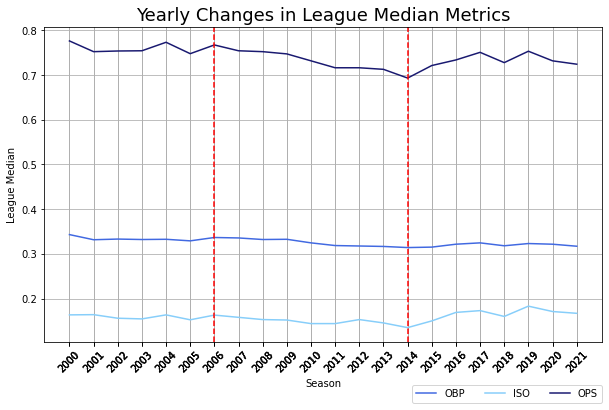

In [29]:
# compare how league median "OBP", "ISO", and "OPS" changed over time
median_metrics = season_df[["OBP", "ISO", "OPS"]].median().reset_index()
melted_df = median_metrics.melt("Season", var_name = "Metrics", value_name = "League Median")

fig, ax = plt.subplots(figsize = (10, 6))

sns.lineplot(x = "Season", y = "League Median", hue = "Metrics", data = melted_df,
             palette = ["royalblue", "lightskyblue", "midnightblue"])
plt.xticks(melted_df["Season"], rotation = 45)
plt.title("Yearly Changes in League Median Metrics", fontsize = 18)
plt.legend(bbox_to_anchor= (0.83, -0.12), loc = "upper center", ncol = 3)
plt.axvline(x = 2006, color='red', linestyle = "--")
plt.axvline(x = 2014, color='red', linestyle = "--")
plt.grid()
fig.subplots_adjust(bottom = 0.15)
plt.show()

Note that the Y-axis represents the league *median* values of the corresponding team batting metrics. The reason I used median intead of mean is to remove the impact of outliers. <br>
While both leauge median **OBP** and **ISO** stayed constant over the past 20 years, league median **OPS** seemed to vary from era to era.

What's interesting about this line plot is that the historical changes in league median OPS matches historical changes in league average RS that we've observed from the bar plot as previosuly. The common trends are:
- **Steroid Era**: During the steroid era, teams achieved the highest team OPS and RS ever since 2000.
- **Post-steroid Era**: Then teams' overall offensive ability (OPS and RS) kept decreasing uptil 2014.
- **Fly-ball Revolution Era**After the 2014 season, teams seemed to recover their offensive ability.

### ⚠️ Caveat
Note that the names of era segmentation came from common knowledge in MLB, and thus, they have nothing to do with any causal relationships between the names of era and the changes/trends. <br>
That is to say, although 2000-2006 seasons were grouped into Steroid Era, **it doesn't mean** steroids and other PEDs certainly helped teams score many runs **nor** the hitter-friendly RS environment during the early 2000's is attributable to steroids. <br>
Likewise, we cannot conclude that the decreases in league median OPS and average RS resulted from strengthened drug testings and penalties. (after the [Mitchell report](https://en.wikipedia.org/wiki/Mitchell_Report) released in 2007) <br>
Therefore, finding out what factors affected such changes in teams' offensive abilities requires further thorough research.

# 🚀 Conclusion <a name="conclusion"></a>
In the early 2000's, there was an important move toward how baseball operations should understand baseball with the help of statistics and new technologies in MLB. As a result, some old-fashioned and conventional baseball wisdoms/strategies were proven to be wrong by sabermetricians. They tried to statistically analyze baseball to provide teams with more efficent ways of winning the ball game **by minimizing the costs of wins**. <br>
This is what we know from the book and movie: **[Moneyball](https://www.imdb.com/title/tt1210166/)**.

In this notebook, I revisited Moneyball to figure out what makes team win in baseball in terms of teams' offesive ability: **Team Runs Scored**.

Some findings are:
### EDA
- There were statistically significant historical changes in the league average RS. That is, **Era** segmentation was a significant factor that affected the league average RS.

- Apart from **Era**, **League** (American League vs National League to which teams belong) was another significant factor that affected the league average RS and it was proven that American League teams scored slightly more runs than National League teams over the past 20 years (i.e., AL was a more hitter-friendly league than NL)

- Nevertheless, no interaction effect bewteen **Era** and **League** were found.

### Regression
- In the multiple linear regression model, both team **OBP** and **ISO** were selected as the two most significant predictors for team RS prediction. Such a regression model explained approximately 85.8% of total variations in team RS with an RMSE of 26.86 and MAE of 21.20 (through 10-fold cross-validation).

- In the simple linear regression model, team **OPS** was used as the single best predictor to estimate team RS. It explains approximately 87.1% of total variations in team RS with an RMSE of 25.48 and MAE of 19.79 (trhough 10-fold cross-validation).

- As the simple linear regressino model predicts team RS slightly better with a fewer number of predictors, the simple linear regression model is considered a better model to make predictions about team RS than the multiple linear regression model.

### OBP, ISO and OPS
For those of you who are not familiar with baseball, let's talk more about what those three predictors actually measure in baseball.

#### OBP (On-base Percentage)
As the name suggests, OBP is simply **the probability that a batter reaches base per plate appearances**. For example, if a batter hit 2 home runs, 1 single and walked twice (i.e., two [base-on balls](https://www.mlb.com/glossary/standard-stats/walk)) in 10 plate appearances, his OBP is 0.500. Essentially it measures how frequently batters/teams reach bases per plate appearances.

#### ISO (Isolated Power)
Isolated power is calculated as follows: $\text{Slugging Percentage}-\text{Batting Average}$. <br>
Without having to understand what slugging percentage and batting average are, ISO quantifies **the raw power of a batter** by taking into account *extra-base hits (i.e, 2B, 3B and Home Runs)*. That is, it measures *a hitter's ability to advance base runners* who has reached bases ahead of his plate appearance.

#### OPS (On-base Plus Slugging)
OPS is the sum of **OBP** and **[SLG](https://www.mlb.com/glossary/standard-stats/slugging-percentage)**. We now know what OBP is but what's SLG? SLG is a hitting metric that gives different credits/weights to [1B](https://www.mlb.com/glossary/standard-stats/single), [2B](https://www.mlb.com/glossary/standard-stats/double), [3B](https://www.mlb.com/glossary/standard-stats/triple) and [HR](https://www.mlb.com/glossary/standard-stats/home-run). <br>
The formula is: $\text{SLG}=\frac{\text{1B} \ + \ \text{2B} \ ×\ 2 \ + \ \text{3B} \ ×\ 3 \ + \ \text{HR} \ ×\ 4}{\text{At-bats}}$. Basically it measures how a hitter contributed to his team by giving different weights/credits to various hitting events that he made.

Therefore, if we sum OBP and SLG, we obtain **OPS**, which quantifies a hitter's ability to reach bases (OBP) and to hit extra-base hits (2B, 3B, and HR) with different weights (SLG).

⚠️ Technically, OPS is an imperfect way to measure a batter's (or team's) offesive ability as it has several drawbacks. <br>
First, while OBP is a probability, SLG is not a probability (it can exceed 1). Thus, mathematically, it makes no sense to sum a probability and non-probability. Second, the different weights assigned to different hitting events (i.e., 1 for 1B, 2 for 2B, 3 for 3B, 4 for HR) in SLG are proven to be overestimated. For this reason, most sabermetricians argue that OPS is relatively less accurate than other advanced hitting metrics.

### How a team scores runs in baseball?
After understanding what each of these metrics measure in baseball, we're now in a better position to understand the multiple and simple linear regression model that we built above. The nature of baseball: How does a team run score in baseball? <br>
First, batters need to reach bases. Then the next batters must advance the hitters who has reached bases earlier (i.e., baserunners). If a baserunner reaches home plate going through the first, second and third base, your score one run.

This is how a baseball team scores runs. It's fixed. There's no other way of scoring runs in baseball. (Note that a hitter reaches bases, advance and bring himself home through a home run).

First, let's think about our **multiple linear regression model**:

$$\hat{{Team RS}}=-774.43+3766.41(\text{Team OBP})+1815.95(\text{Team ISO})$$

As I said, **OBP** measures *how frequently a batter reaches bases*, while **ISO** quantifies the raw power of a hitter by taking into account extra-base hits (2B, 3B, and HR) that *advances baserunners*. Sounds familiar right? It sounds like the multiple linear regression is a quantified formula of how a team score runs in baseball, although it's not perfect (as there's no perfect model in statistics).

Next, the **simple linear regression model**: 

$$\hat{\text{Team RS}}=-779.74+2048.87(\text{Team OPS})$$

Although OPS is an imperfect measurement, we easily notice that OPS actually encompasses the measurement of how frequently hitters reaches bases and the measurement of how frequently hitters advance baserunners by taking into account extra-base hits: **OBP + SLG = OPS**.

🚀 **Bottom line**: Both simple and multiple linear regression models capture the nature of baseball!

#### 😄 P.S
Thank you for reading this long notebook and I hope you enjoy reading my analysis.

If you liked my analysis, it'd be much appreciated if you upvote this notebook so other people can also enjoy my analysis :)

If you have any questions/doubts about my analysis, feel free to comment below. I'd love to hear feedback and advice from you!